In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import warnings

import numpy as np
import gsw
import xarray as xr
from xgcm import Grid
from xhistogram.xarray import histogram
from dask.diagnostics import ProgressBar

import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import regionmask

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean

import cartopy.crs as ccrs
import cartopy.feature as cfeature
data_crs = ccrs.PlateCarree()

In [38]:
import xwmb.theta as xwm
import sectionate as sec
import regionate as reg

In [39]:
import dask

### Load grids and data

In [53]:
gridname = 'rho2'
dt = 'timestp' # choose from ['monthly', '6hourly', 'timestp']

# Load data on native grid
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/ocean_'+dt+'/'
prefix = '19000101.ocean_'+dt+'_'
time = "190*_*"

# Diagnostics were saved into different files
suffixs = ['thck','heat','salt','xtra']
Zprefixes = {'rho2':'rho2_', 'zstr':'z_', 'natv':'z'}
Zprefix = Zprefixes[gridname]
ds = xr.Dataset()
for suffix in suffixs:
    filename = prefix+gridname+'_'+suffix+'_'+time+'*.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])
    
# Load snapshot data (for mass tendency term)
suffix = 'snap'
filename = prefix+gridname+'_'+suffix+'_'+time+'*.nc'
snap = xr.open_mfdataset(rootdir+filename)

#  Load grid
oceangridname = '19000101.ocean_static.nc'
grid = xr.open_dataset(rootdir+oceangridname).squeeze()

# Cut off the first time-averaged entry in ds, because snap does not come with the initial condition
if dt=='timestp':
    pass
    #ds = ds.sel(time=ds.time[::2])
ds = ds.isel(time=slice(1,None))

# Some renaming to match hdrake conventions
ocean_grid = grid.copy().rename({'depth_ocean':'deptho'})
ds = ds.rename({'temp':'thetao'})
snap = snap.rename({'temp':'thetao'})

# z-coordinate dataset containing basic state variables
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'},
                        'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'} },
           periodic=None)

# z-coordinate dataset containing basic state variables
grid_snap = Grid(snap, coords={'X': {'center': 'xh',},
                        'Y': {'center': 'yh',},
                        'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'} },
           periodic=None)

In [54]:
ds = ds.sel(time=slice('1900-02-01 00', '1901-02-01 00'))
snap = snap.sel(time=slice('1900-02-01 00', '1901-02-01 00'))

In [32]:
def plot_basin(b):
    plt.figure(figsize=(10, 7))
    plt.subplot(facecolor="grey")
    da_plot = ds['thetao'].isel({'time':0, f'{Zprefix}l':0}).where(b.mask)
    vmin, vmax = da_plot.min().values, da_plot.max().values
    pc = plt.pcolormesh(
        ocean_grid['geolon'], ocean_grid['geolat'],
        da_plot,
        alpha=1.0, cmap="RdBu_r",
        vmin=vmin, vmax=vmax
    )
    plt.plot(b.lons_input, b.lats_input, "C3o", markersize=5)
    plt.plot(b.lons_uv, b.lats_uv, "k+", markersize=3., alpha=0.9, markeredgewidth=0.5)
    plt.plot(b.lons, b.lats, "k-", linewidth=0.5)

In [33]:
def compute_basin_wmb(lons, lats, name):
    b = reg.conform_basin_to_ocean_grid(reg.Basin(lons, lats, name), ocean_grid)
    plot_basin(b)

    wmb = xwm.calc_wmb_theta(
        ds, grid, snap, grid_snap, ocean_grid,
        b.mask, b.i, b.j
    )
    wmb.to_zarr(f'/work/hfd/CM4-highres-WMT/data/Baltic_test_wmbs/wmb_{b.name}_{gridname}_{dt}', mode="w")
    fig, axes = xwm.plot_wmb(wmb)
    axes[0].set_title(f"Watermass budget for '{b.name}' domain, computed from '{dt}' diagnostics in '{gridname}' coordinates.", loc="left")
    return wmb

## Full-domain (but using the arbitrary domain method)

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:1109: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:303: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.<function raw_interp_function at 0x2ab028c6e950>` instead of `Axis.<function raw_interp_function at 0x2ab028c6e950>`
  warnings.warn(
/work/hfd/.conda/envs/ge

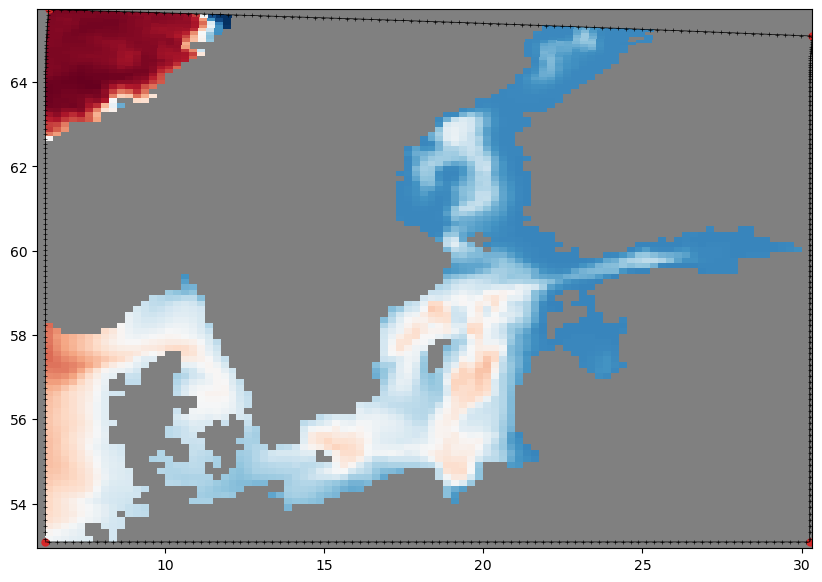

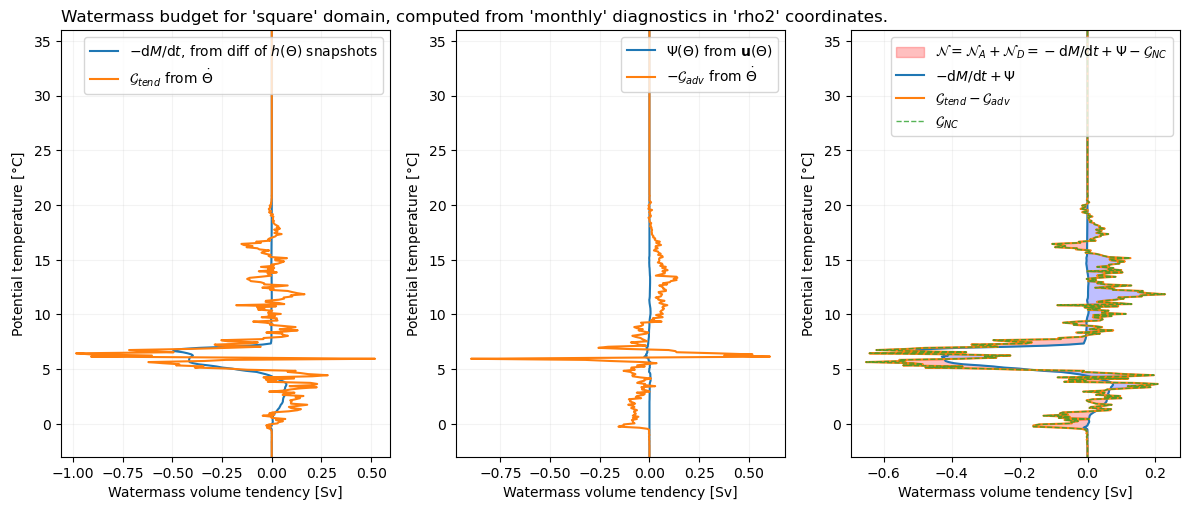

In [34]:
# box that bounds full domain (except first column and row, because grid is symmetric)
lons = np.array([
    ocean_grid['geolon_c'].isel(xq=0, yq=0),
    ocean_grid['geolon_c'].isel(xq=-1, yq=0),
    ocean_grid['geolon_c'].isel(xq=-1, yq=-1),
    ocean_grid['geolon_c'].isel(xq=0, yq=-1)])
lats = np.array([
    ocean_grid['geolat_c'].isel(xq=0, yq=0),
    ocean_grid['geolat_c'].isel(xq=-1, yq=0),
    ocean_grid['geolat_c'].isel(xq=-1, yq=-1),
    ocean_grid['geolat_c'].isel(xq=0, yq=-1)])
wmb = compute_basin_wmb(lons, lats, "square")

## Arbitrary sub-domain

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:1109: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:303: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.<function raw_interp_function at 0x2ab028c6e950>` instead of `Axis.<function raw_interp_function at 0x2ab028c6e950>`
  warnings.warn(
/work/hfd/.conda/envs/ge

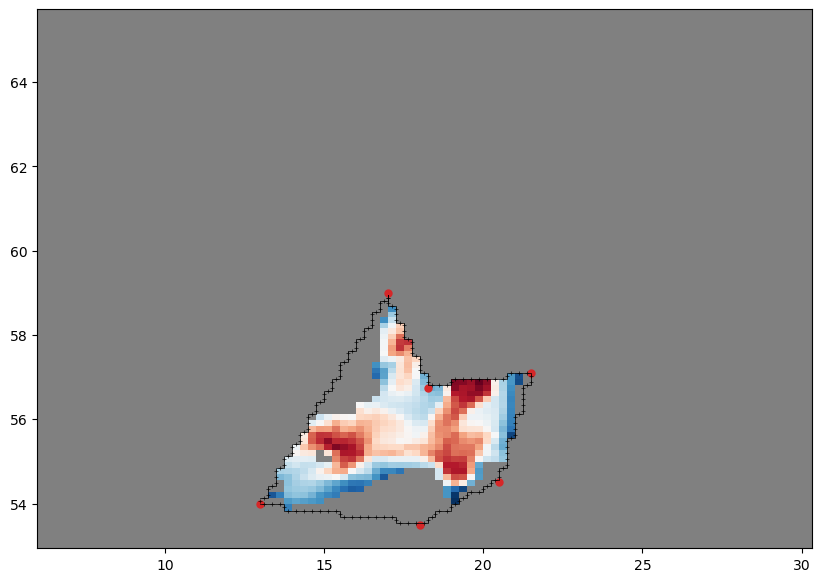

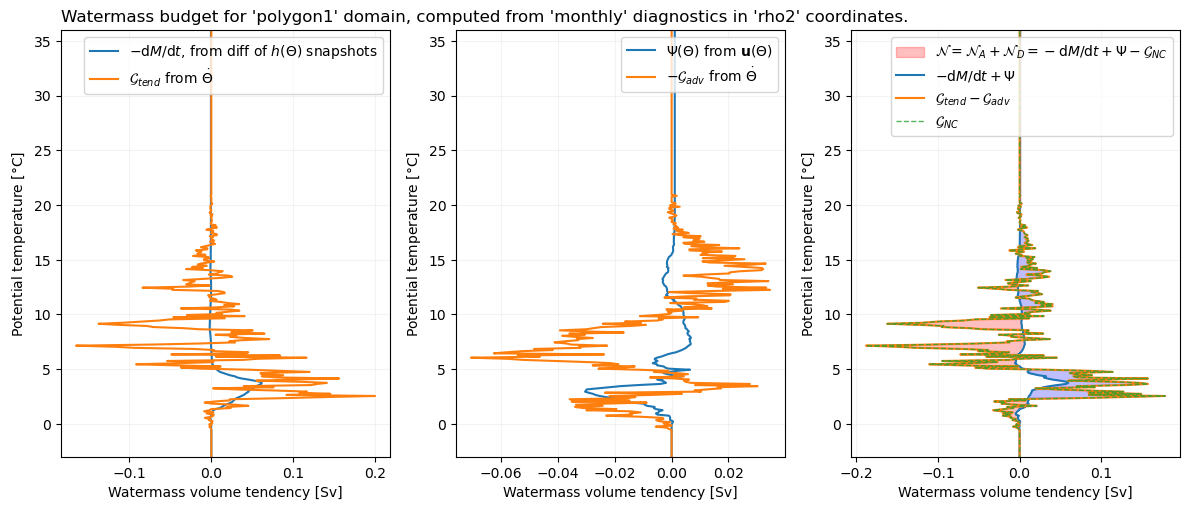

In [35]:
lons = np.array([13, 18, 20.5, 21.5, 18.25, 17])
lats = np.array([54., 53.5, 54.5, 57.1, 56.75, 59])
wmb = compute_basin_wmb(lons, lats, "polygon1")